In [1]:
# OPTIONAL INSTALLS
# Purpose: Install required libraries if they are not already available in your environment.
# Notes: Comment out if your environment already has these.
#!pip install -q gymnasium numpy matplotlib

In [2]:
pip install "gymnasium[toy-text]"


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# ENV + FRAME CAPTURE HELPERS (OFFICIAL RENDERER)
# Purpose:
#   - Create FrozenLake-v1 (8x8, slippery=True) with Gym/Gymnasium's official renderer
#   - Provide helpers to roll out a policy and capture frames in notebooks

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# Gym import with fallback
try:
    import gymnasium as gym
except Exception:
    import gym

def make_env(seed: int = 0, is_slippery: bool = True, map_name: str = "8x8", render_mode: str = "rgb_array_list"):
    """
    Input:
      - seed (int): Random seed for env.reset.
      - is_slippery (bool): If True, stochastic transitions (slippery ice).
      - map_name (str): '4x4' or '8x8' FrozenLake layout.
      - render_mode (str): 'rgb_array_list' for notebook frames, or 'human' for a window.

    Output:
      - env (gym.Env): Initialized FrozenLake environment with the requested settings.
    """
    env = gym.make("FrozenLake-v1", map_name=map_name, is_slippery=is_slippery, render_mode=render_mode)
    env.reset(seed=seed)
    return env

def random_policy_fn(env):
    """
    Input:
      - env (gym.Env): Any Gym/Gymnasium environment with a discrete action space.

    Output:
      - policy (callable): A function policy(s) -> action that samples uniformly at random.
    """
    return lambda _s: env.action_space.sample()

def rollout_capture_frames(env, policy, max_steps: int = 400, seed: int | None = None):
    """
    Input:
      - env (gym.Env): FrozenLake environment created with render_mode='rgb_array_list'.
      - policy (callable): Function policy(s) -> action.
      - max_steps (int): Safety cap on episode length.
      - seed (int|None): Optional seed for env.reset.

    Output:
      - frames (list[np.ndarray]): List of RGB frames from the official renderer.
    """
    if seed is not None:
        s, info = env.reset(seed=seed)
    else:
        s, info = env.reset()

    done = False
    frames = []
    while not done and len(frames) < max_steps:
        a = policy(s)
        s, r, terminated, truncated, info = env.step(a)
        done = terminated or truncated
        all_frames = env.render()  # returns all frames so far
        if all_frames:
            frames.append(all_frames[-1])
    return frames

def animate_official_frames(frames, title="FrozenLake 8×8 (slippery) — official renderer", interval_ms: int = 140):
    """
    Input:
      - frames (list[np.ndarray]): RGB frames (H×W×3 or 4).
      - title (str): Title shown above the animation.
      - interval_ms (int): Delay between frames in milliseconds.

    Output:
      - html_anim (IPython.display.HTML): HTML object rendering the animation inline.
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(frames[0])
    ax.axis("off")
    ax.set_title(title)

    def update(i):
        im.set_data(frames[i])
        return (im,)

    ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=interval_ms, blit=True)
    plt.close(fig)
    return HTML(ani.to_jshtml())


In [4]:
# DEMO: RANDOM WALK + ANIMATION
# Purpose:
#   - Demonstrate the animation
#   - Show a 4×4 slippery random walk animation inline

env_demo = make_env(seed=42, is_slippery=True, map_name="4x4", render_mode="rgb_array_list")
frames_demo = rollout_capture_frames(env_demo, random_policy_fn(env_demo), max_steps=150, seed=42)
animate_official_frames(frames_demo, "FrozenLake 4×4 (slippery)")




## Task 1 — Understanding the Random Policy & Computing the True Value (γ = 1)

**Context.**  
In this task, we study the **uniform-random policy** on the FrozenLake-v1 environment (4×4, `is_slippery=True`).  
Under this policy, the agent selects each of the four actions (left, down, right, up) **with equal probability (¼ each)**, regardless of its current state.  
This makes the behavior completely random, no preference toward the goal, and it ensures that all transitions are eventually explored.

With **γ = 1**, the value of each state \( V^\pi(s) \) can be interpreted very intuitively:

> \( V^\pi(s) = \Pr_\pi(\text{eventually reaching the GOAL before falling into a hole }|\; S_0=s) \)

The true value function \(V^\pi\) can be computed analytically by solving a linear system over **non-terminal (transient)** states only.  
We exclude the absorbing states (holes and goal) to make the system non-singular.

---

### Learning Objectives
- Interpret \(V^\pi(s)\) as the **probability of success** when γ = 1.  
- Compute the **true value function** \(V^\pi\) by solving the system \((I - Q)v = r\).  
- Understand **properness**: a policy is proper if it reaches an absorbing state with probability 1.

---

### What You’ll Do
1. Run the provided cell to compute the exact \(V^\pi\) for the random policy.  
2. Visualize the resulting value grid as a heatmap.  
3. Observe how the value increases closer to the goal and remains 0 in holes and at the goal itself.

---

### Be Prepared to Explain
- What the **random policy** does in FrozenLake and why it is “proper.”  
- Why holes and the goal have a value of 0.  
- Which states have higher success probability and why.  
- What is the meaning of the value of a partiuclar state in this example?




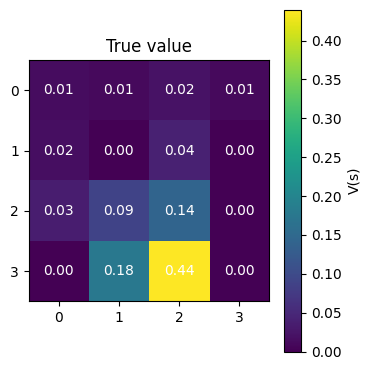

In [5]:
# ==============================================================
# Task 1 — Understanding the Policy and Computing the True Value (γ=1)
# ==============================================================
# Goal:
#   - Understand the random policy being evaluated.
#   - Compute the exact value function analytically by solving (I - P)v = r
#     over NON-terminal (transient) states.
#   - Interpret values as the probability of eventually reaching the goal.
# ==============================================================

import numpy as np
import matplotlib.pyplot as plt

try:
    import gymnasium as gym
except Exception:
    import gym

# --------------------------------------------------------------
# Environment utilities
# --------------------------------------------------------------

def make_env_train(seed: int = 0, is_slippery: bool = True, map_name: str = "4x4"):
    """Create a FrozenLake-v1 environment (no renderer) for training/evaluation."""
    env = gym.make("FrozenLake-v1", map_name=map_name, is_slippery=is_slippery)
    env.reset(seed=seed)
    return env

def _decode_map(env):
    """Return grid map as list of lists of characters."""
    desc = env.unwrapped.desc
    return [[c.decode("utf-8") for c in row] for row in desc]

def show_value_grid(V: np.ndarray, title: str = "Value grid (4×4)", map_name: str = "4x4"):
    """Plot value function as a 4×4 heatmap."""
    n = 4 if map_name == "4x4" else 8
    G = V.reshape(n, n)
    plt.figure(figsize=(3.8, 3.8))
    plt.imshow(G, origin="upper")
    plt.colorbar(label="V(s)")
    plt.title(title)
    for r in range(n):
        for c in range(n):
            plt.text(c, r, f"{G[r,c]:.2f}", ha="center", va="center", color="white")
    plt.xticks(range(n)); plt.yticks(range(n))
    plt.tight_layout()
    plt.show()

# --------------------------------------------------------------
# Exact value computation for γ=1 (non-terminal linear system)
# --------------------------------------------------------------

def exact_value_for_random_policy_gamma1(env, tol: float = 1e-10):
    """
    Input:
      - env (gym.Env): FrozenLake env; transitions read from env.unwrapped.P
      - tol (float): Numerical tolerance for singularity/properness checks.

    Output:
      - V (np.ndarray): True state-value function under the uniform random policy (γ=1).
                        V(s) = Probability of eventually reaching the goal from state s.

    Method:
      - Identify absorbing states (holes, goal) and remove them.
      - Build Q and r over non-terminals under uniform random policy:
            v = (I - Q)^(-1) * r
      - Check if (I - Q) is invertible; if not, raise an informative error.
    """
    nS = env.observation_space.n
    nA = env.action_space.n
    gamma = 1.0

    # Identify absorbing states
    grid = _decode_map(env)
    n = len(grid)
    absorbing, goal_states = set(), set()
    for r in range(n):
        for c in range(n):
            idx = r * n + c
            ch = grid[r][c]
            if ch in ("H", "G"):
                absorbing.add(idx)
            if ch == "G":
                goal_states.add(idx)

    nonterm = [s for s in range(nS) if s not in absorbing]
    idx_map = {s: i for i, s in enumerate(nonterm)}
    m = len(nonterm)

    Q = np.zeros((m, m), dtype=float)
    r = np.zeros(m, dtype=float)
    action_prob = 1.0 / nA

    for s in nonterm:
        i = idx_map[s]
        for a in range(nA):
            for (p, ns, rew, done) in env.unwrapped.P[s][a]:
                if ns in absorbing:
                    r[i] += action_prob * p * (1.0 if ns in goal_states else 0.0)
                else:
                    j = idx_map[ns]
                    Q[i, j] += action_prob * p

    I = np.eye(m)
    A = I - Q
    try:
        eigvals = np.linalg.eigvals(Q)
        rho = max(abs(eigvals)) if eigvals.size else 0.0
        if rho >= 1.0 - 1e-12:
            raise np.linalg.LinAlgError(
                f"(I - Q) may be singular (ρ(Q)={rho:.6f}). "
                "The policy might be improper (non-absorbing)."
            )
        v = np.linalg.solve(A, r)
    except np.linalg.LinAlgError as e:
        raise RuntimeError(
            "Failed to solve (I - Q)v = r for γ=1. "
            "This suggests the policy may be improper (not guaranteed to reach absorption).\n"
            f"Details: {e}"
        )

    V = np.zeros(nS)
    for s in nonterm:
        V[s] = v[idx_map[s]]
    return V

# --------------------------------------------------------------
# Compute and reflect
# --------------------------------------------------------------

env_reflect = make_env_train(seed=0, is_slippery=True, map_name="4x4")
V_true = exact_value_for_random_policy_gamma1(env_reflect)
show_value_grid(V_true, title="True value")


<span style="color:orange">

### Interpretation 

**Reflection**:

- Each value V(s) is the probability of eventually reaching the goal under the random policy.

- Terminal states (holes, goal) have value 0 because they are absorbing.

- The start state's value shows how likely a random agent is to succeed on slippery ice.

**Value Policy**
highest in (2,3) = 0.44, loewst in all row 0 = 0.01

**Random Policy**
selects each action (R,L,D,U) uniformly (1/4 each) regardless of state.

**Why it is “proper”** 
From every state it will eventually suceed to reach the goal. 
-> so absorption is guaranteed and (I − Q) is invertible for non-terminals.

**Why holes and goal have value 0** 
Reward = 0, since both terminate the episode. 

**Which states have higher success probability** 

- states closer (in transition-probability terms) to the goal -- most direct path

- states from which many transition paths lead to the goal rather than holes.

Because those have the highest probability to be led to the goal, without ending in a hole first. 

**Meaning of Vπ(s) for γ=1**
the probability, under the policy π, that an episode starting in s eventually ends in the goal (rather than a hole).
y=1 is the discount factor - controls how much the agent values future rewards relative to immediate ones, Y=1 means the agent vlues future rewards equally to immediate ones. 

**(I - q) is singular, how does this relate to properness?**

=confirmation if a policy is proper

means that there is a non-zero probability to for any state. 

</span>


## Task 2 — Monte Carlo vs TD(0) Prediction for the Random Policy (γ = 1)

**Context.**  
Now we estimate the same value function \(V^\pi\) (for the **random policy**) using two learning methods:

- **Monte Carlo (MC)** — estimates values by averaging the *total return* (0 or 1 in FrozenLake) over many episodes.  
  Each update is based only on complete episodes, and updates occur once per state per episode (first-visit).  
- **TD(0)** — learns online after every step using a bootstrapped target \( r + γ V(s') \).  
  TD can learn faster initially, but its behavior depends strongly on the **step-size schedule**.

Both methods are evaluated on the same random policy as in Task 1.  
With γ = 1, the value \(V(s)\) again represents the **probability of eventually reaching the goal**.

---

### Learning Objectives
- Observe how MC and TD(0) learn the true value function from sampled experience.  
- Compare their convergence behavior and variance.  
- Understand the effect of different **step-size schedules** in TD(0):  
  - `"constant"`: fast early learning but noisy convergence.  
  - `"inverse"`: slower updates but very stable.  
  - `"inverse_sqrt"`: a balanced compromise between speed and stability.

---

### What You’ll Do
1. **MC snapshots:**  
   - Run the cell showing how the MC value grid evolves after 0, 200, 400, … episodes.  
   - You can change `EPISODES` and `SNAPSHOT_EVERY` to experiment.  
2. **TD(0) snapshots:**  
   - Run the TD version and **change**  
     ```python
     SCHEDULE = "inverse_sqrt"   # or "constant", "inverse"
     ALPHA0   = 0.1              # base step-size
     ```  
     to see how step-size affects learning speed and stability.  
3. **MSE comparison:**  
   - Run the comparison cells to see how MC and TD(0) differ in mean-squared error (MSE) as a function of episodes.

---

### Be Prepared to Explain
- The main steps of the MC and TD(0) algorithms.  
- How MC and TD(0) differ in when and how they update their estimates.  
- Why TD(0) with a constant α may oscillate around the true values.  
- How diminishing step-size schedules help TD(0) stabilize and reduce variance.  
- Which method converges faster early and which one is more stable later.

<span style="color:orange">

### Interpretation 

**Monte Carlo Algorithm**

1.	Initialize value estimates V(s).
2.	Generate a full episode following the policy.
3.	For each state visited, compute the return G (sum of rewards to episode end).
4.	Option A: use first-visit — update only first time a state appears; Option B: every-visit — update every time.
5.	Update V(s) toward the observed return (e.g., average past returns or incremental mean).
6.	Repeat for many episodes until values converge.

**TD(0) Algorithm**

1.	Initialize value estimates V(s).
2.	Start an episode and observe current state s.
3.	Take an action, observe reward r and next state s’.
4.	Compute TD target: r + gamam V(s’).
5.	Update V(s) <- V(s) + alpha(r + gamma V(s’) - V(s)).
6.	Continue step-by-step (online) until episode ends; repeat many episodes.

**Algorithmic difference**

  | Aspect              | Monte Carlo                  | TD(0)                           |
| ------------------- | ---------------------------- | ------------------------------- |
| Update frequency    | End of episode               | After every step                |
| Target value        | Actual return G_t            | Estimated R + γV(S')            |
| Episode requirement | Needs complete episodes      | Works with incomplete sequences |
| Bias                | Unbiased (uses true returns) | Biased (uses estimates)         |
| Variance            | High variance                | Lower variance                  |
| Memory              | Stores entire episode        | Minimal memory                  |

=> MC estimates values after every episode, TD(0) after every step 
=> MC updates on the average actual return from each states first visit, TD(0) uses the bootstrapped estimate of immediate reward + next state reward

**Why TD(0) with a constant α may oscillate around the true values.**
- the new updates will always be the same
- new experiences -> fixed size correction -> continuous adjustment 

**How diminishing step-size schedules help TD(0) stabilize and reduce variance.**

- Constant α: Fast but never stops bouncing around the answer (like a ball that never stops rolling)

- Diminishing α: Starts fast, gradually slows down, and eventually settles exactly on the answer (like a ball with friction that eventually stops)

**Which method converges faster early** -> TD(0), lower variance

**and which one is more stable later.** -> MC, lower bias

**more suitable for continuing tasks?**
- TD(0), because it updates after every step, MC needs a terminated episode. 



In [6]:
# ==============================================================
# Task 2 — Monte Carlo vs TD(0) Prediction (γ=1)
# ==============================================================
# Goal:
#   - Estimate V^π from sampled episodes.
#   - Compare Monte Carlo and TD(0) learning.
#   - Observe convergence toward the true analytical values from Task 1.
#
# What you need to do:
#   - Just runt this code
#   - Be prepered to explain what is happinging in the main steps of MC and
#     TD(0) algorithms, thouse are clearly marked.
# ==============================================================

from dataclasses import dataclass
from typing import Callable, List, Tuple

def run_episode(env, policy, max_steps: int = 400, seed: int | None = None):
    """Run a single episode using a given policy."""
    if seed is not None:
        s, info = env.reset(seed=seed)
    else:
        s, info = env.reset()
    done = False
    states, actions, rewards = [], [], []
    while not done and len(states) < max_steps:
        a = policy(s)
        s2, r, terminated, truncated, info = env.step(a)
        states.append(s); actions.append(a); rewards.append(r)
        s = s2
        done = terminated or truncated
    return states, actions, rewards

def random_policy_fn(env):
    """Uniform random policy."""
    return lambda _s: env.action_space.sample()

# --------------------------------------------------
#  Algorithms with progress snapshots
# --------------------------------------------------

@dataclass
class MCPredictionResult:
    V: np.ndarray
    returns_count: np.ndarray

def mc_prediction_first_visit_progress(env, policy: Callable[[int], int],
                                       gamma: float = 1.0, episodes: int = 2000,
                                       snapshot_every: int = 200) -> List[Tuple[int, np.ndarray]]:
    """
    Input:
      - env (gym.Env): FrozenLake environment (no renderer recommended for speed).
      - policy (callable): policy(s) -> action used to generate episodes.
      - gamma (float): Discount factor; here default is 1.0 (episodic).
      - episodes (int): Number of episodes to sample.
      - snapshot_every (int): Save a copy of V after every this-many episodes.

    Output:
      - snapshots (list[(int, np.ndarray)]): List of (episode_index, V_copy) pairs,
        including (0, V_init) BEFORE any updates.

    Notes:
      - First-visit MC: update each state only at its first visit per episode.
    """
    nS = env.observation_space.n
    V = np.zeros(nS, dtype=float)
    returns_sum = np.zeros(nS, dtype=float)
    returns_count = np.zeros(nS, dtype=float)
    snapshots: List[Tuple[int, np.ndarray]] = []

    # Snapshot at initialization (episode 0)
    snapshots.append((0, V.copy()))

    for ep in range(1, episodes + 1):
        states, actions, rewards = run_episode(env, policy)
        G = 0.0
        visited = set()
        for t in reversed(range(len(states))):
            s_t = states[t]
            r_tp1 = rewards[t]
            G = gamma * G + r_tp1
            if s_t not in visited:
                visited.add(s_t)
                # =========================================================
                # === Be prepered to expalin what is happening here =======
                # =========================================================
                returns_sum[s_t] += G
                returns_count[s_t] += 1.0
                V[s_t] = returns_sum[s_t] / returns_count[s_t]
                # =========================================================
                # =========================================================
                # =========================================================
                ### Monte Carlo estimate of Value function V for a first visit 
                ### Every time we see a state again, we update its value to be the average return from all its past visits.
        if ep % snapshot_every == 0:
            snapshots.append((ep, V.copy()))
    return snapshots

def td0_prediction_progress(env, policy,
                            gamma: float = 1.0,
                            alpha0: float = 0.1,
                            episodes: int = 2000,
                            snapshot_every: int = 200,
                            step_size_schedule: str = "constant"):
    """
    Input:
      - env (gym.Env): FrozenLake environment (tabular).
      - policy (callable): policy(s) -> action.
      - gamma (float): Discount factor (γ=1.0 for probability-of-success view).
      - alpha0 (float): Base step-size (interpreted per schedule).
      - episodes (int): Number of training episodes.
      - snapshot_every (int): Save a copy of V every this many episodes.
      - step_size_schedule (str): One of {"constant", "inverse", "inverse_sqrt"}.
         * "constant":      α_t(s) = alpha0
         * "inverse":       α_t(s) = alpha0 / (1 + N_t(s))
         * "inverse_sqrt":  α_t(s) = alpha0 / sqrt(1 + N_t(s))

    Output:
      - snapshots (list[(int, np.ndarray)]): (episode_index, V_copy) pairs,
        including (0, V_init) BEFORE any updates.

    Notes:
      - Uses terminal-safe TD target: target = r  if done  else r + γ V[s2].
      - We increment N(s) BEFORE computing α_t(s), so the very first visit uses 1 in the denominator.
    """
    import numpy as np

    # validate schedule
    valid = {"constant", "inverse", "inverse_sqrt"}
    if step_size_schedule not in valid:
        raise ValueError(f"step_size_schedule must be one of {valid}, got {step_size_schedule!r}")

    nS = env.observation_space.n
    V = np.zeros(nS, dtype=float)
    visits = np.zeros(nS, dtype=float)  # per-state visit counter
    snapshots = [(0, V.copy())]         # include initialization

    for ep in range(1, episodes + 1):
        s, info = env.reset()
        done = False
        while not done:
            a = policy(s)
            s2, r, terminated, truncated, info = env.step(a)
            done = terminated or truncated

            # increment visits BEFORE computing α_t(s)
            visits[s] += 1.0

            if step_size_schedule == "constant":
                alpha = alpha0
            elif step_size_schedule == "inverse":
                alpha = alpha0 / (1.0 + visits[s])
            elif step_size_schedule == "inverse_sqrt":
                alpha = alpha0 / np.sqrt(1.0 + visits[s])

            # =========================================================
            # === Be prepered to expalin what is happening here =======
            # =========================================================
            target = r if done else (r + gamma * V[s2])
            V[s] += alpha * (target - V[s])
            # =========================================================
            # =========================================================
            # =========================================================
            ### TD(0) update rule.
            ### If the episode ended, the target is just the reward r. Otherwise, it’s the reward plus the discounted value of the next state V(s’).
            ### Update the value of the current state s by taking a small step (learning rate alpha) toward the TD target.
            #  We update V(s) toward the one-step lookahead estimate of the return.
            
            s = s2

        if ep % snapshot_every == 0:
            snapshots.append((ep, V.copy()))

    return snapshots



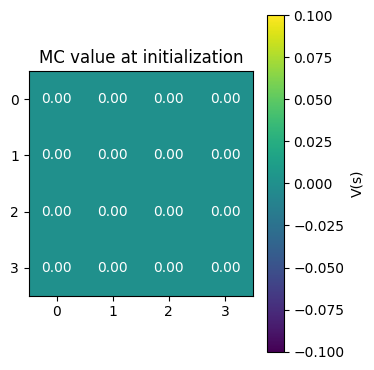

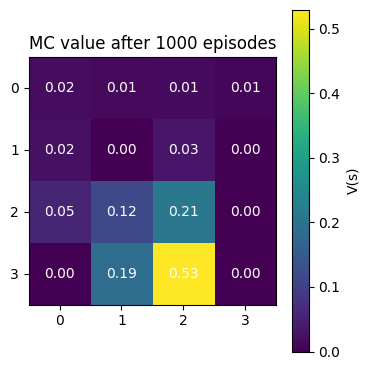

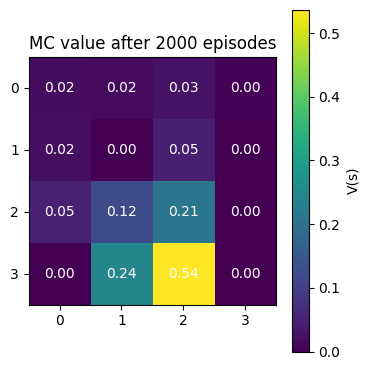

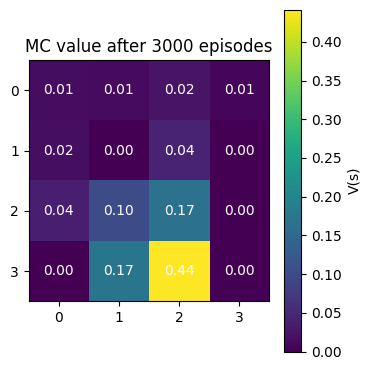

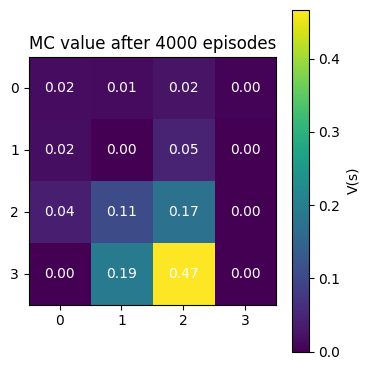

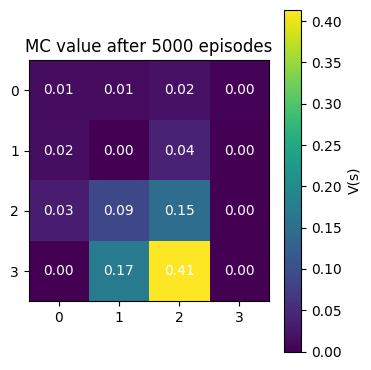

In [7]:
# MC (First-Visit) SNAPSHOTS (γ=1) — initialization + reflection
# Purpose:
#   - Visualize how First-Visit Monte Carlo (MC) estimates the value function when γ=1
#     (here, V(s) = probability of eventually reaching the goal under the random policy).
#   - Include an initialization snapshot (episode 0) to show the starting point (all zeros).
#   - Let students change only the experiment knobs: total episodes and snapshot cadence.
#
# Be prepared to explain what is happening:
#   • MC collects complete episodes and, for each state's FIRST visit in an episode, uses the
#     full return G_t (0 or 1 in FrozenLake with γ=1) to update V(s) by averaging.
#   • Because rewards are sparse (only at the goal), successful episodes are rare at first;
#     early estimates can stay near zero until a success occurs. As more episodes arrive,
#     per-state sample means stabilize (variance shrinks with more visits).
#   • The value grid typically “brightens” first near states that frequently precede the goal,
#     then propagates as more trajectories hit diverse states before success.
#   • Compare the result with the true value we computed in Task 1.
#
#
# You can play with:
#   - EPISODES: total training episodes (e.g., 1000–10000)
#   - SNAPSHOT_EVERY: how often to capture snapshots (e.g., 100, 200, 500)

# --- Configuration you can tweak ---
EPISODES       = 5000
SNAPSHOT_EVERY = 1000

# --- Create env and policy ---
env_mc = make_env_train(seed=1, is_slippery=True, map_name="4x4")
policy = random_policy_fn(env_mc)

# --- Run MC with snapshots (includes episode 0 initialization) ---
mc_snaps = mc_prediction_first_visit_progress(env_mc, policy,
                                              gamma=1.0,
                                              episodes=EPISODES,
                                              snapshot_every=SNAPSHOT_EVERY)

# --- Show value grids for all snapshots (episode 0 included) ---
for ep, V in mc_snaps:
    title = ("MC value at initialization"
             if ep == 0 else
             f"MC value after {ep} episodes")
    show_value_grid(V, title=title, map_name="4x4")



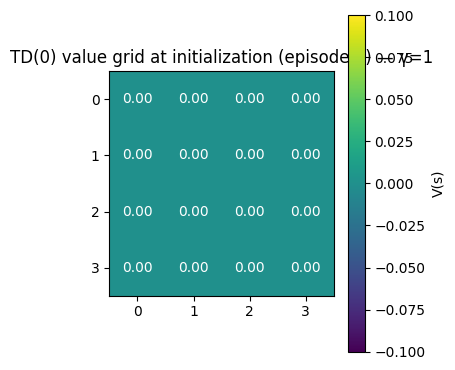

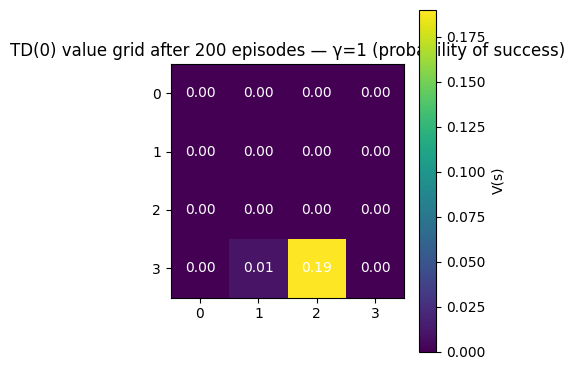

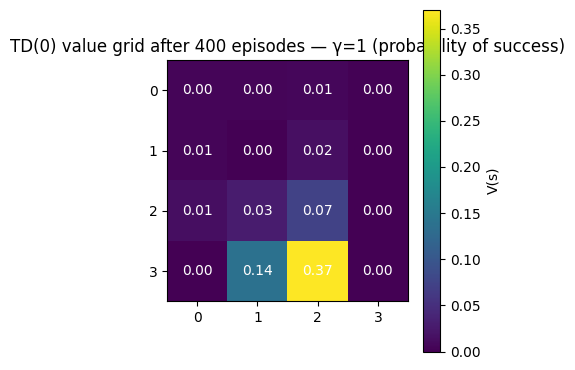

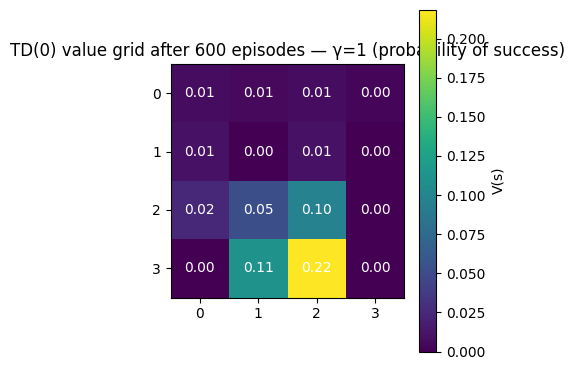

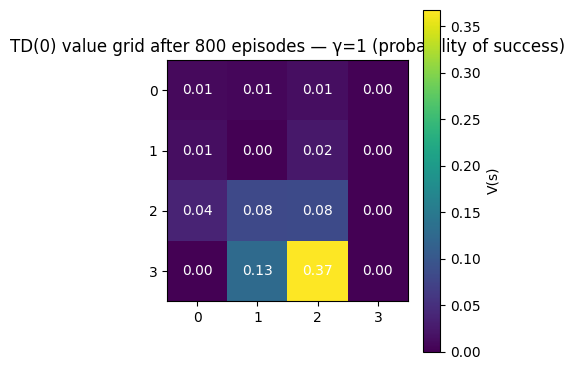

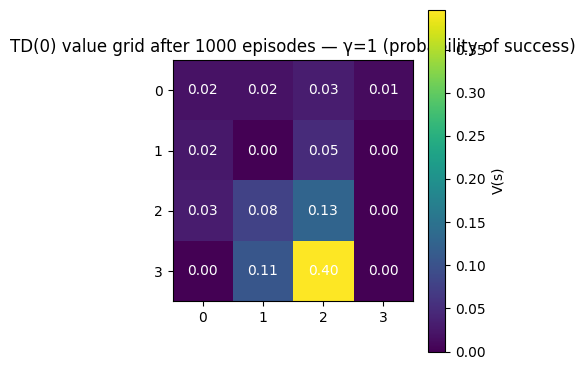

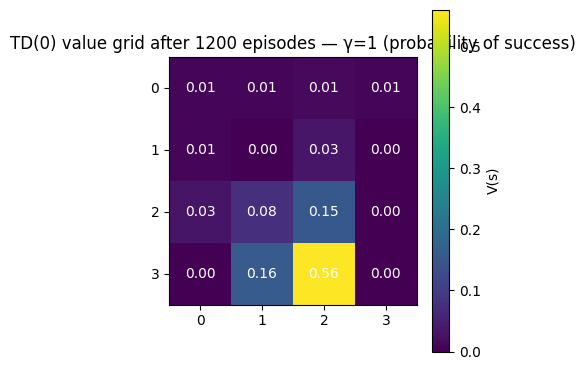

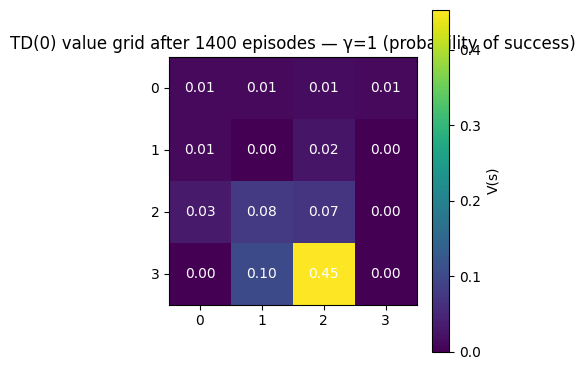

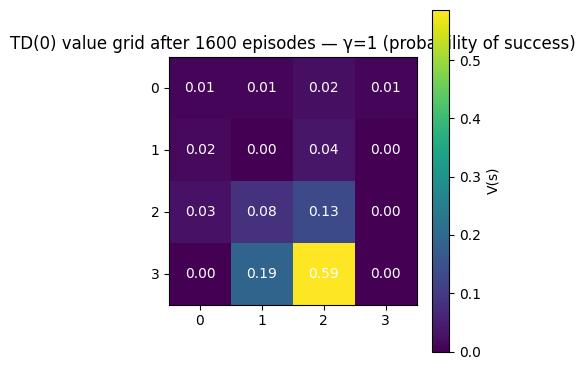

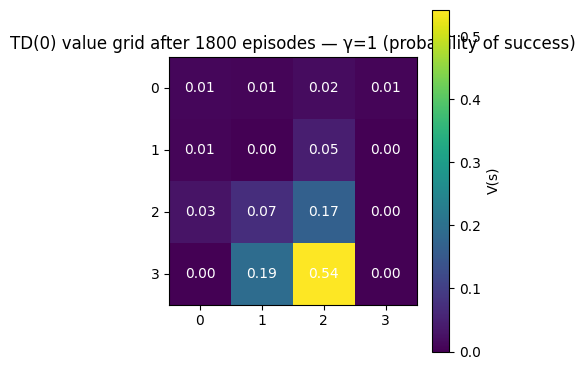

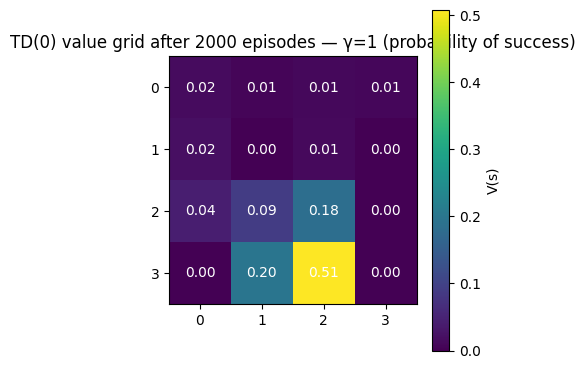

In [8]:
# TD(0) SNAPSHOTS (γ=1) — step-size schedules + initialization snapshot
# Purpose:
#   - Visualize how TD(0) learns the value function (probability of success when γ=1)
#   - Compare different step-size schedules: "constant", "inverse", "inverse_sqrt"
#   - Include an initialization snapshot (episode 0) to show the starting point (all zeros)
#
# Be prepared to explain what is happening:
#   • With γ=1, V(s) estimates the probability of eventually reaching the goal (under the random policy).
#   • TD(0) updates online using targets: target = r (if terminal) else r + γ V(s').
#   • Step-size schedule matters:
#       - "constant": α_t(s)=α0 → fast early learning but higher variance / nonzero noise floor.
#       - "inverse": α_t(s)=α0/(1+N_t(s)) → slow but very stable; lowest final variance/MSE.
#       - "inverse_sqrt": α_t(s)=α0/sqrt(1+N_t(s)) → compromise between speed and stability.
#   • Compare the result with the true value we computed in Task 1.
#
# You can play with:
#   - `episodes`: total training episodes (e.g., 1000–5000)
#   - `alpha0`: base step-size (try 0.02, 0.05, 0.1, 0.2)
#   - `snapshot_every`: how often to capture snapshots (e.g., 100, 200, 500)
#   - `step_size_schedule`: "constant", "inverse", or "inverse_sqrt"

# --- Configuration you can tweak ---
EPISODES       = 2000
ALPHA0         = 0.1
SNAPSHOT_EVERY = 200
SCHEDULE       = "constant"  # {"constant", "inverse", "inverse_sqrt"}

# --- Create env and policy ---
env_td = make_env_train(seed=2, is_slippery=True, map_name="4x4")
policy = random_policy_fn(env_td)

# --- Run TD(0) with chosen schedule (includes episode 0 snapshot) ---
td_snaps = td0_prediction_progress(env_td, policy,
                                   gamma=1.0,
                                   alpha0=ALPHA0,
                                   episodes=EPISODES,
                                   snapshot_every=SNAPSHOT_EVERY,
                                   step_size_schedule=SCHEDULE)

# --- Show value grids for all snapshots (episode 0 included) ---
for ep, V in td_snaps:
    title = ("TD(0) value grid at initialization (episode 0) — γ=1"
             if ep == 0 else
             f"TD(0) value grid after {ep} episodes — γ=1 (probability of success)")
    show_value_grid(V, title=title, map_name="4x4")

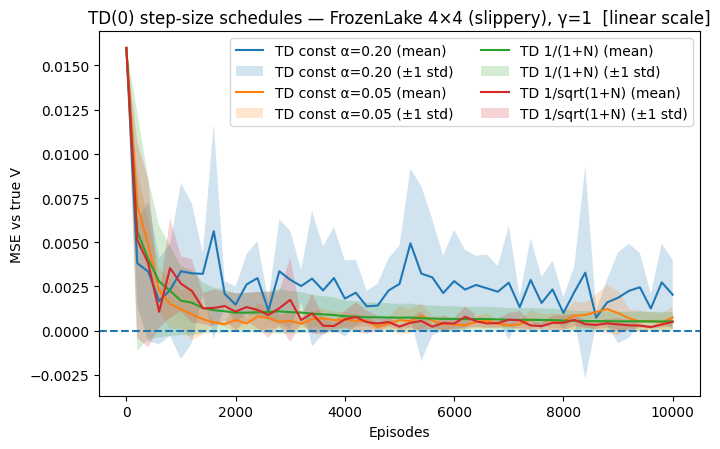

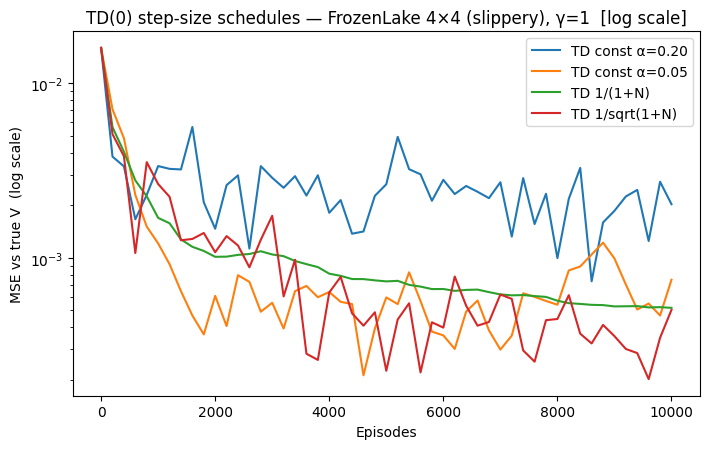

In [9]:
# Experiment: Compare TD(0) step-size schedules via MSE vs Episodes (γ=1)
# Purpose:
#   - Systematically compare how different step-size schedules affect TD(0) learning on FrozenLake 4×4.
#   - Plot MSE (vs. the γ=1 exact value) as a function of training episodes.
#   - Provide BOTH: (1) linear y-axis with mean ± std and a y=0 reference line,
#                    (2) log-scale y-axis with means only (no variance band).
#
# Prereqs:
#   - exact_value_for_random_policy_gamma1(env)  # γ=1, non-terminal solver with properness check
#   - td0_prediction_progress(env, policy, ..., step_size_schedule=...)
#   - make_env_train, random_policy_fn
#
# Be prepared to explain what is happening:
#   • We measure how closely TD(0) estimates match the true V^π (probability of success) over time.
#   • Step-size schedules trade off SPEED vs STABILITY:
#       - "constant" α: faster early learning, but higher variance and a nonzero late-time noise floor.
#       - "inverse"  α_t(s)=α0/(1+N_t(s)): slowest but most stable; tends to lowest final MSE.
#       - "inverse_sqrt" α_t(s)=α0/sqrt(1+N_t(s)): a pragmatic middle ground (faster than inverse, steadier than constant).
#   • We average over multiple random trials and show variability with ±1 std on a linear scale.
#   • The log-scale figure highlights early-episode differences (means only; std bands don’t mix with logs).
#
# You can play with:
#   - EPISODES: try 1000–10000
#   - SNAPSHOT_EVERY: e.g., 100/200/500
#   - TRIALS: more trials → smoother means/std (but slower)
#   - TD_SETTINGS: add/remove schedules or tweak alpha0 for "constant"

import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Config: episodes, trials, etc.
# -------------------------------
TRIALS        = 5
EPISODES      = 10000
SNAPSHOT_EVERY= 200
GAMMA         = 1.0

# Compare these TD(0) settings
TD_SETTINGS = [
    {"label": "TD const α=0.20",      "schedule": "constant",      "alpha0": 0.20},
    {"label": "TD const α=0.05",      "schedule": "constant",      "alpha0": 0.05},
    {"label": "TD 1/(1+N)",           "schedule": "inverse",       "alpha0": 1.0},
    {"label": "TD 1/sqrt(1+N)",       "schedule": "inverse_sqrt",  "alpha0": 1.0},
]

def compute_mse_curve(snapshots, V_star):
    """
    Input:
      - snapshots: list[(episode_index, V_vector)], including (0, V_init).
      - V_star: exact value vector (γ=1).
    Output:
      - eps, mses: arrays aligned by episode index.
    """
    eps  = np.array([ep for ep, _ in snapshots], dtype=int)
    mses = np.array([float(np.mean((V - V_star)**2)) for _, V in snapshots], dtype=float)
    return eps, mses

def mean_std_over_trials(all_eps, all_mses):
    """
    Aggregate MSE curves across trials (assumes same episode indices).
    """
    eps = all_eps[0]
    M   = np.stack(all_mses, axis=0)   # [trials, time]
    mean= M.mean(axis=0)
    std = M.std(axis=0, ddof=1) if M.shape[0] > 1 else M.std(axis=0)
    return eps, mean, std

def safe_for_log(y, eps=1e-12):
    """Clamp to avoid zeros on a log axis (purely for plotting)."""
    return np.maximum(y, eps)

# -------------------------------
# Ground-truth V^π (γ=1)
# -------------------------------
env_star = make_env_train(seed=0, is_slippery=True, map_name="4x4")
V_star   = exact_value_for_random_policy_gamma1(env_star)

# -------------------------------
# Run experiments
# -------------------------------
results = []  # list of dicts per setting: {label, eps, mean, std}
for i, cfg in enumerate(TD_SETTINGS):
    eps_list, mse_list = [], []
    for k in range(TRIALS):
        # Stagger seeds per setting & trial
        seed = 1000 + 100*i + k
        env  = make_env_train(seed=seed, is_slippery=True, map_name="4x4")
        pol  = random_policy_fn(env)
        snaps= td0_prediction_progress(env, pol,
                                       gamma=GAMMA,
                                       alpha0=cfg["alpha0"],
                                       episodes=EPISODES,
                                       snapshot_every=SNAPSHOT_EVERY,
                                       step_size_schedule=cfg["schedule"])
        e, m = compute_mse_curve(snaps, V_star)
        eps_list.append(e); mse_list.append(m)
    eps, mean, std = mean_std_over_trials(eps_list, mse_list)
    results.append({"label": cfg["label"], "eps": eps, "mean": mean, "std": std})

# -------------------------------
# Figure 1: Linear y-axis with ±1 std and y=0 reference line
# -------------------------------
plt.figure(figsize=(7.2, 4.6))
for res in results:
    plt.plot(res["eps"], res["mean"], label=f"{res['label']} (mean)")
    plt.fill_between(res["eps"], res["mean"]-res["std"], res["mean"]+res["std"], alpha=0.2,
                     label=f"{res['label']} (±1 std)")
plt.axhline(0.0, linestyle="--")  # convergence reference
plt.xlabel("Episodes")
plt.ylabel("MSE vs true V")
plt.title("TD(0) step-size schedules — FrozenLake 4×4 (slippery), γ=1  [linear scale]")
plt.legend(ncols=2)
plt.tight_layout()
plt.show()

# -------------------------------
# Figure 2: Log-scale y-axis, means only
# -------------------------------
plt.figure(figsize=(7.2, 4.6))
for res in results:
    plt.plot(res["eps"], safe_for_log(res["mean"]), label=res["label"])
plt.yscale("log")
plt.xlabel("Episodes")
plt.ylabel("MSE vs true V  (log scale)")
plt.title("TD(0) step-size schedules — FrozenLake 4×4 (slippery), γ=1  [log scale]")
plt.legend()
plt.tight_layout()
plt.show()


<span style="color:orange">

### Interpretation 

**Linear** = absolute difference in error, 

- Constant step sizes (α=0.20 and α=0.05) learn quickly at the beginning.
- α=0.20 stays very noisy even after many episodes → high variance.
- α=0.05 is more stable and eventually becomes the best of the constant schedules.
- Inverse schedule (1/(1+N)) learns slower but steadily decreases the error with almost no variance.
- Inverse-sqrt (1/sqrt(1+N)) learns faster than inverse and ends up performing similarly to α=0.05, with moderate variance.

**The log scale reveals long-term differences:** = shows us more the tiny differences
- The inverse schedule keeps improving slowly even after 10,000 episodes.
- The constant schedules plateau early and oscillate around a noise floor.
- Inverse-sqrt decreases faster than the inverse schedule early on but converges slightly less cleanly.



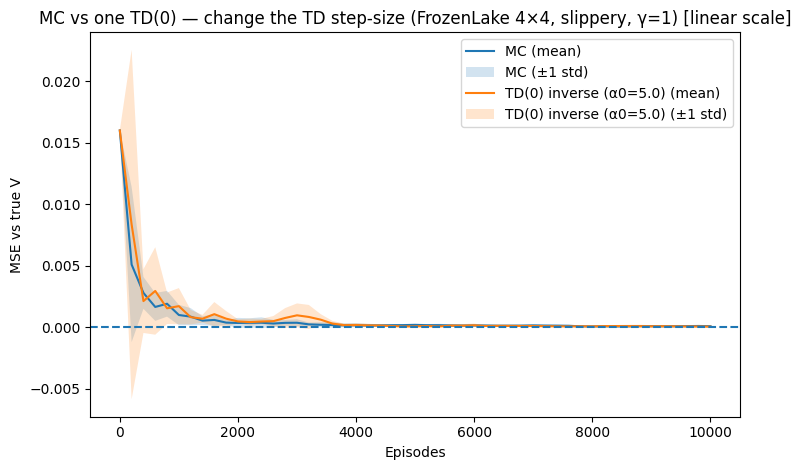

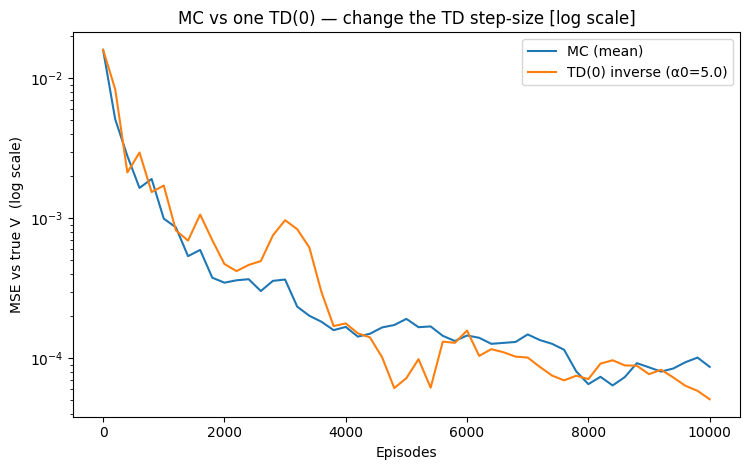

In [10]:
# MC vs ONE TD(0) — make the TD step-size easy to change (γ=1)
# Purpose:
#   - Compare First-Visit MC against a SINGLE TD(0) configuration.
#   - ***Students: change the TD step-size HERE*** to explore how it affects speed & stability.
#   - Plots:
#       (1) Linear y-axis with mean ± std and a y=0 reference line.
#       (2) Log-scale y-axis with means only (std bands don’t mix with logs).
#
# Be prepared to explain what is happening:
#   • MC (first-visit) averages full returns → unbiased; variance shrinks with visits.
#   • TD(0) bootstraps: faster early propagation; behavior depends on step-size:
#       - "constant": α_t(s)=α0 → fast start, higher variance, nonzero noise floor.
#       - "inverse": α_t(s)=α0/(1+N_t(s)) → slow but very stable; lowest final MSE.
#       - "inverse_sqrt": α_t(s)=α0/sqrt(1+N_t(s)) → compromise between speed and stability.
#
# You can play with (recommended knobs for students):
#   - TRIALS (e.g., 3–7), EPISODES (1000–10000), SNAPSHOT_EVERY (100–500)


import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Experiment configuration
# -------------------------------
TRIALS         = 5
EPISODES       = 10000
SNAPSHOT_EVERY = 200
GAMMA          = 1.0

# ====== YOU CAN CHANGE THIS PART ======
TD_SCHEDULE = "inverse"   # one of: "constant", "inverse", "inverse_sqrt"
TD_ALPHA0   = 5.0              # base step-size (meaning depends on schedule)
# ==========================================

# -------------------------------
# Helpers (assumes earlier cells defined):
#   - make_env_train, random_policy_fn
#   - mc_prediction_first_visit_progress
#   - td0_prediction_progress (supports step_size_schedule)
#   - exact_value_for_random_policy_gamma1
# -------------------------------
def compute_mse_curve(snapshots, V_star):
    """
    Input:
      - snapshots: list[(episode_index, V_vector)], includes (0, V_init)
      - V_star: exact value vector
    Output:
      - eps, mses
    """
    eps  = np.array([ep for ep, _ in snapshots], dtype=int)
    mses = np.array([float(np.mean((V - V_star)**2)) for _, V in snapshots], dtype=float)
    return eps, mses

def mean_std_over_trials(all_eps, all_mses):
    """
    Aggregate MSE curves across trials (assumes same episode indices).
    """
    eps = all_eps[0]
    M   = np.stack(all_mses, axis=0)
    mean= M.mean(axis=0)
    std = M.std(axis=0, ddof=1) if M.shape[0] > 1 else M.std(axis=0)
    return eps, mean, std

def safe_for_log(y, eps=1e-12):
    """Clamp to avoid zeros on a log axis (for plotting only)."""
    return np.maximum(y, eps)

# -------------------------------
# Exact V^π (γ=1) for reference
# -------------------------------
env_star = make_env_train(seed=0, is_slippery=True, map_name="4x4")
V_star   = exact_value_for_random_policy_gamma1(env_star)

# -------------------------------
# MC baseline
# -------------------------------
mc_eps_list, mc_mses_list = [], []
for k in range(TRIALS):
    env_mc = make_env_train(seed=100 + k, is_slippery=True, map_name="4x4")
    pol_mc = random_policy_fn(env_mc)
    mc_snaps = mc_prediction_first_visit_progress(env_mc, pol_mc,
                                                  gamma=GAMMA,
                                                  episodes=EPISODES,
                                                  snapshot_every=SNAPSHOT_EVERY)
    e_mc, m_mc = compute_mse_curve(mc_snaps, V_star)
    mc_eps_list.append(e_mc); mc_mses_list.append(m_mc)

eps_mc, mean_mc, std_mc = mean_std_over_trials(mc_eps_list, mc_mses_list)

# -------------------------------
# TD(0) — single configuration (students change TD_SCHEDULE/TD_ALPHA0 above)
# -------------------------------
td_eps_list, td_mses_list = [], []
for k in range(TRIALS):
    env_td = make_env_train(seed=200 + k, is_slippery=True, map_name="4x4")
    pol_td = random_policy_fn(env_td)
    td_snaps = td0_prediction_progress(env_td, pol_td,
                                       gamma=GAMMA,
                                       alpha0=TD_ALPHA0,
                                       episodes=EPISODES,
                                       snapshot_every=SNAPSHOT_EVERY,
                                       step_size_schedule=TD_SCHEDULE)
    e_td, m_td = compute_mse_curve(td_snaps, V_star)
    td_eps_list.append(e_td); td_mses_list.append(m_td)

eps_td, mean_td, std_td = mean_std_over_trials(td_eps_list, td_mses_list)

# -------------------------------
# Figure 1: Linear y-axis with mean ± std, plus y=0 reference line
# -------------------------------
plt.figure(figsize=(7.6, 4.8))
plt.plot(eps_mc, mean_mc, label="MC (mean)")
plt.fill_between(eps_mc, mean_mc - std_mc, mean_mc + std_mc, alpha=0.2, label="MC (±1 std)")

label_td = f'TD(0) {TD_SCHEDULE} (α0={TD_ALPHA0})'
plt.plot(eps_td, mean_td, label=f"{label_td} (mean)")
plt.fill_between(eps_td, mean_td - std_td, mean_td + std_td, alpha=0.2, label=f"{label_td} (±1 std)")

plt.axhline(0.0, linestyle="--")
plt.xlabel("Episodes")
plt.ylabel("MSE vs true V")
plt.title("MC vs one TD(0) — change the TD step-size (FrozenLake 4×4, slippery, γ=1) [linear scale]")
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# Figure 2: Log-scale y-axis (means only)
# -------------------------------
plt.figure(figsize=(7.6, 4.8))
plt.plot(eps_mc, safe_for_log(mean_mc), label="MC (mean)")
plt.plot(eps_td, safe_for_log(mean_td), label=label_td)
plt.yscale("log")
plt.xlabel("Episodes")
plt.ylabel("MSE vs true V  (log scale)")
plt.title("MC vs one TD(0) — change the TD step-size [log scale]")
plt.legend()
plt.tight_layout()
plt.show()





<span style="color:orange" >

### Interpretation 

- With a good decreasing step size (inverse with α₀=5), TD(0) performs almost identically to Monte Carlo.
- both methods converge rapidly to extremely low MSE (almost zero).
- MC has slightly more variance early on because it updates only at episode end, while TD(0) updates every step.

## Task 3 — SARSA vs Q-learning (ε-greedy exploration)

**Context.**  
We now switch from *prediction* (estimating \(V^\pi\)) to *control* (learning an action-value function \(Q(s,a)\) to improve behavior).  
We compare two classic tabular control algorithms under **ε-greedy exploration**:

- **SARSA (on-policy):** updates toward the value of the action actually taken next:
  \[
  Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha \bigl[ R_{t+1} + \gamma\, Q(S_{t+1}, A_{t+1}) - Q(S_t,A_t) \bigr].
  \]
- **Q-learning (off-policy):** updates toward the greedy action value:
  \[
  Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha \bigl[ R_{t+1} + \gamma \max_{a'} Q(S_{t+1}, a') - Q(S_t,A_t) \bigr].
  \]

Both *behave* with the **same ε-greedy policy** during training (exploration), but the **target** differs (on-policy vs off-policy).

**Setup.**  
- Environment: FrozenLake-v1 (4×4, `is_slippery=True`), γ = 1 (episodes terminate at holes/goal, so undiscounted returns are well-defined).  
- Exploration: ε-greedy over \(Q\), with user-set ε (constant here for simplicity).

**What you’ll do.**
1. Train **SARSA** and **Q-learning** for the same number of episodes (same α and ε).  
2. Track **success rate** (probability of reaching the goal) with a moving average.  
3. Compare learning curves.

**Be prepared to explain.**
- The main steps off SARSA and Q-learning.  
- How does SARSA and Q-learning differ? Which one is on-policy and which one off-policy, and why?
- How ε and α affect speed vs stability of both algorithms.


In [11]:
# ==============================================================
# Task 3 — SARSA vs Q-learning (ε-greedy control): helpers
# --------------------------------------------------------------
# Provides:
#   • argmax_random_tie(x, rng): choose a max index uniformly at random among ties.
#   • epsilon_greedy_action(Q, s, epsilon, nA, rng): ε-greedy using random tie-breaking.
#   • evaluate_success_rate(env, Q, episodes=..., epsilon_eval=0.0, seed=None):
#       runs greedy (or ε-greedy if epsilon_eval>0) rollouts using random tie-breaking.
#   • moving_average(x, k): simple smoothing helper for curves.
# ==============================================================

import numpy as np

def argmax_random_tie(x: np.ndarray, rng: np.random.RandomState | None = None) -> int:
    """
    Input:
      - x (np.ndarray): 1D array of action values, e.g., Q[s].
      - rng (np.random.RandomState | None): RNG for reproducibility (optional).
    Output:
      - idx (int): index of a maximum value, chosen uniformly at random among all max ties.
    """
    if rng is None:
        rng = np.random
    max_val = np.max(x)
    candidates = np.flatnonzero(x == max_val)
    return int(rng.choice(candidates))

def epsilon_greedy_action(Q: np.ndarray, s: int, epsilon: float, nA: int,
                          rng: np.random.RandomState | None = None) -> int:
    """
    Input:
      - Q (np.ndarray): Q-table of shape [nS, nA].
      - s (int): current state.
      - epsilon (float): exploration probability in [0,1].
      - nA (int): number of actions.
      - rng (np.random.RandomState | None): RNG for reproducibility (optional).
    Output:
      - a (int): action selected by ε-greedy with RANDOM tie-breaking for the greedy choice.
    """
    if rng is None:
        rng = np.random
    if rng.rand() < epsilon:
        return int(rng.randint(nA))
    return argmax_random_tie(Q[s], rng)

def evaluate_success_rate(env, Q: np.ndarray, episodes: int = 200,
                          epsilon_eval: float = 0.0, seed: int | None = None) -> float:
    """
    Input:
      - env: FrozenLake environment (no renderer).
      - Q (np.ndarray): learned Q-table [nS, nA].
      - episodes (int): number of evaluation episodes.
      - epsilon_eval (float): ε for evaluation policy (0.0 → purely greedy).
      - seed (int | None): RNG seed for deterministic evaluation (optional).
    Output:
      - success_rate (float): fraction of episodes that end in the goal (reward 1).
    Notes:
      - Uses RANDOM tie-breaking among greedy actions to avoid bias toward action index 0.
    """
    rng = np.random.RandomState(seed) if seed is not None else np.random
    nA = env.action_space.n
    successes = 0
    for _ in range(episodes):
        s, info = env.reset()
        done = False
        while not done:
            if epsilon_eval > 0.0 and rng.rand() < epsilon_eval:
                a = int(rng.randint(nA))
            else:
                a = argmax_random_tie(Q[s], rng)
            s, r, terminated, truncated, info = env.step(a)
            done = terminated or truncated
            if done and r == 1.0:
                successes += 1
    return successes / episodes

def moving_average(x: np.ndarray, k: int = 50) -> np.ndarray:
    """
    Input:
      - x (np.ndarray): 1D array of values (e.g., success rates).
      - k (int): window size (k>=1).
    Output:
      - y (np.ndarray): moving-average smoothed array, same length as x.
    """
    k = max(1, int(k))
    x = np.asarray(x, dtype=float)
    if len(x) == 0:
        return x
    csum = np.cumsum(np.insert(x, 0, 0.0))
    core = (csum[k:] - csum[:-k]) / k  # length = len(x)-k+1
    y = np.empty_like(x, dtype=float)
    # pad the first k-1 with the first computed average for a full-length series
    y[:k-1] = core[0]
    y[k-1:] = core
    return y



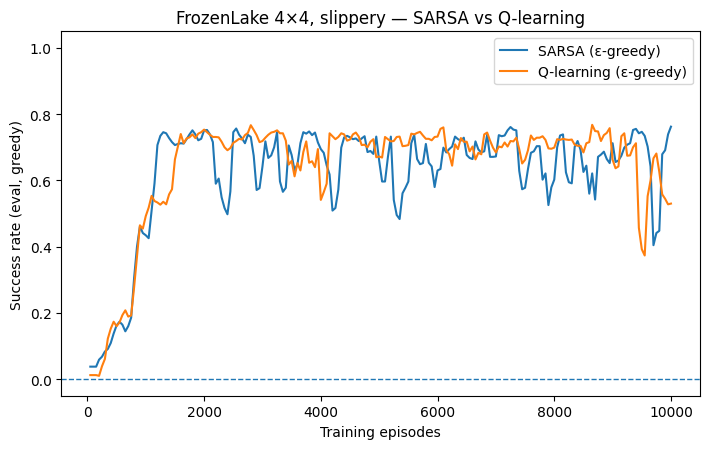

In [12]:
# ==============================================================
# Task 3: SARSA vs Q-learning with ε-greedy + RANDOM TIE-BREAKING
# ==============================================================

import numpy as np
import matplotlib.pyplot as plt

def train_sarsa(env, episodes=5000, alpha=0.1, epsilon=0.1, gamma=1.0, seed=0, log_every=50):
    """
    Input:
      - env: FrozenLake env
      - episodes (int): training episodes
      - alpha (float): step-size
      - epsilon (float): ε for ε-greedy behavior
      - gamma (float): discount factor (γ=1.0 here)
      - seed (int): RNG seed
      - log_every (int): evaluate success rate every N episodes
    Output:
      - Q (np.ndarray): learned Q-table [nS, nA]
      - logs (dict): {"episodes": np.ndarray, "success": np.ndarray}
    Notes:
      - On-policy target uses the ACTUAL next action a' sampled ε-greedily.
      - RANDOM tie-breaking is used inside epsilon_greedy_action for stability.
    """
    rng = np.random.RandomState(seed)
    nS, nA = env.observation_space.n, env.action_space.n
    Q = np.zeros((nS, nA), dtype=float)

    episodes_axis, success_curve = [], []

    for ep in range(1, episodes + 1):
        s, info = env.reset()
        a = epsilon_greedy_action(Q, s, epsilon, nA, rng)
        done = False
        while not done:
            s2, r, terminated, truncated, info = env.step(a)
            done = terminated or truncated

            if done:
                target = r                      # terminal, no bootstrap
                Q[s, a] += alpha * (target - Q[s, a])
                break

            a2 = epsilon_greedy_action(Q, s2, epsilon, nA, rng)
            target = r + gamma * Q[s2, a2]     # SARSA on-policy target
            Q[s, a] += alpha * (target - Q[s, a])

            s, a = s2, a2

        if ep % log_every == 0:
            episodes_axis.append(ep)
            success_curve.append(evaluate_success_rate(env, Q, episodes=300, epsilon_eval=0.0))

    return Q, {"episodes": np.array(episodes_axis), "success": np.array(success_curve)}


def train_qlearning(env, episodes=5000, alpha=0.1, epsilon=0.1, gamma=1.0, seed=1, log_every=50):
    """
    Input/Output: same as train_sarsa.
    Notes:
      - Off-policy target uses max_a' Q[s', a'] (greedy), independent of next sampled action.
      - RANDOM tie-breaking is used during ACTION SELECTION via epsilon_greedy_action.
        (The target uses the VALUE max; tie-breaking is irrelevant there.)
    """
    rng = np.random.RandomState(seed)
    nS, nA = env.observation_space.n, env.action_space.n
    Q = np.zeros((nS, nA), dtype=float)

    episodes_axis, success_curve = [], []

    for ep in range(1, episodes + 1):
        s, info = env.reset()
        done = False
        while not done:
            a = epsilon_greedy_action(Q, s, epsilon, nA, rng)
            s2, r, terminated, truncated, info = env.step(a)
            done = terminated or truncated

            if done:
                target = r
            else:
                target = r + gamma * np.max(Q[s2])  # greedy value backup

            Q[s, a] += alpha * (target - Q[s, a])
            s = s2

        if ep % log_every == 0:
            episodes_axis.append(ep)
            success_curve.append(evaluate_success_rate(env, Q, episodes=300, epsilon_eval=0.0))

    return Q, {"episodes": np.array(episodes_axis), "success": np.array(success_curve)}


# -------- Example run & plot (you can tweak these) --------
GAMMA     = 1.0
EPISODES  = 10000
ALPHA     = 0.1
EPSILON   = 0.1
LOG_EVERY = 50
SEED_SARSA= 2
SEED_QL   = 3

env3 = make_env_train(seed=123, is_slippery=True, map_name="4x4")
#env3 = make_env(seed=123, is_slippery=True, map_name="4x4")

Q_sarsa, log_sarsa = train_sarsa(env3, episodes=EPISODES, alpha=ALPHA, epsilon=EPSILON,
                                 gamma=GAMMA, seed=SEED_SARSA, log_every=LOG_EVERY)
Q_ql,    log_ql    = train_qlearning(env3, episodes=EPISODES, alpha=ALPHA, epsilon=EPSILON,
                                     gamma=GAMMA, seed=SEED_QL,    log_every=LOG_EVERY)

plt.figure(figsize=(7.2, 4.6))
plt.plot(log_sarsa["episodes"], moving_average(log_sarsa["success"], k=3), label="SARSA (ε-greedy)")
plt.plot(log_ql["episodes"],    moving_average(log_ql["success"], k=3),    label="Q-learning (ε-greedy)")
plt.ylim(-0.05, 1.05)
plt.xlabel("Training episodes")
plt.ylabel("Success rate (eval, greedy)")
plt.title("FrozenLake 4×4, slippery — SARSA vs Q-learning")
plt.axhline(0.0, linestyle="--", linewidth=1)
plt.legend()
plt.tight_layout()
plt.show()



<span style="color:orange">

### Interpretation 


**SARSA*** = On-Policy
- Uses the action actually taken next (ε-greedy).
- Learns the value of the behavior policy (the one with exploration).
- ON-Policy: Because it updates its Q-values using the same policy that it follows, including ε-greedy exploration.

1. Observe current state s.
2.	Select an action a using ε-greedy.
3.	Take the action, observe reward r and next state s’.
4.	Choose next action a’ using ε-greedy (same policy).
5.	Update: state and action and repeat


**Q-learning** = Off-Policy
- Uses the best possible action at the next state (greedy).
- Learns the value of the greedy optimal policy, not the behavior policy.
- OFF-Polify: Because it updates Q-values using a different policy than it follows: Behavior policy = ε-greedy (exploring), Target policy = greedy (optimal, exploiting)

1.	Observe current state s.
2.	Select an action a using ε-greedy.
3.	Take action, observe reward r and next state s’.
4.	Compute target using max over next actions:
5.	Choose next action a’ (for behavior), but the update does not depend on it.
6.	Continue.

**Main difference**
- SARSA updates using the action you actually took next (so it learns about the policy you follow).
- Q-learning updates using the best action you could take next (so it learns about the best policy, even if you explore).

**ε — exploration rate**
- High ε: more exploration → more stable, safer learning but slower convergence.
- Low ε: more exploitation → learns faster, but may converge to a suboptimal policy.

**α — learning rate**
- High α: fast updates → quick learning, but high variance and instability.
- Low α: slow updates → stable, smooth learning but slow to adapt or recover.

## Task 4 — Off-Policy Q-learning from Random Behavior (Offline/Batch)

**Context.**  
We now explore the **off-policy** nature of Q-learning by separating:
1) a **behavior policy** that generates data (the *random policy* from Tasks 1–2), and  
2) a **target policy** implicitly defined by Q-learning (greedy w.r.t. \(Q\)).

We will:
- First, **collect a dataset** of transitions \((s,a,r,s',\text{done})\) using the random policy (no learning).  
- Then, run **offline Q-learning** over this fixed dataset (several epochs), updating:
  \[
  Q(s,a) \leftarrow Q(s,a) + \alpha \bigl[ r + \gamma \max_{a'} Q(s',a') - Q(s,a) \bigr].
  \]
No new interaction is used during learning — all updates come from the data buffer.  
This demonstrates **off-policy** learning: the target (greedy) can differ from the behavior (random).

**What you’ll do.**
1. Choose a dataset size (number of random episodes) and collect data with the random policy.  
2. Run batch/offline Q-learning for a few passes (epochs) over the dataset.  
3. Evaluate the **greedy** policy from \(Q\) by its success rate.

**Be prepared to explain.**
- What is the behavioral policy here?
- Is it a good behavioral policy? More generally, what would make a good one?
- The algorithm only learns the optimal Q-table, not the optimal policy. How do we derive a policy from a Q-table, and how do we act greedily with respect to Q?
- Interpret the value heatmap for the greedy policy. Is it optimal?


Collected transitions: 7920


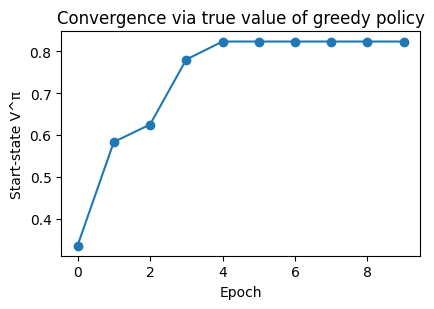

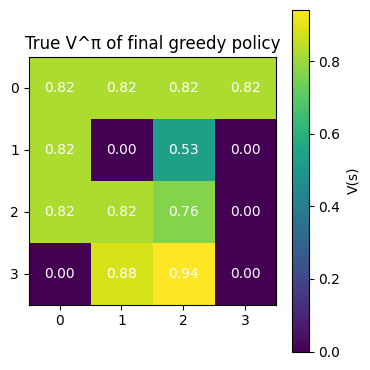

In [13]:
# ==============================================================
# Task 4 — Off-policy Q-learning: convergence via true value, plus heatmaps
# ==============================================================

import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

Transition = Tuple[int, int, float, int, bool]  # (s, a, r, s', done)

# ------------------------
# Dataset and learning
# ------------------------

def collect_dataset_random(env, episodes: int = 1000, max_steps: int = 400, seed: int = 42) -> List[Transition]:
    rng = np.random.RandomState(seed)
    np.random.seed(seed)
    nA = env.action_space.n
    D: List[Transition] = []
    for _ in range(episodes):
        s, info = env.reset()
        done = False
        steps = 0
        while not done and steps < max_steps:
            a = rng.randint(nA)  # uniform random behavior
            s2, r, terminated, truncated, info = env.step(a)
            done = terminated or truncated
            D.append((s, a, float(r), s2, bool(done)))
            s = s2
            steps += 1
    return D

def greedy_policy_array(Q: np.ndarray) -> np.ndarray:
    return np.argmax(Q, axis=1).astype(int)

def offline_q_learning_with_trace(
    env,
    D: List[Transition],
    epochs: int = 25,
    alpha: float = 0.1,
    gamma: float = 1.0,
    seed: int = 7,
):
    """
    Offline Q-learning over a fixed dataset.
    Convergence metric per epoch: true start-state value under current greedy policy (γ=1).
    """
    rng = np.random.RandomState(seed)
    nS, nA = env.observation_space.n, env.action_space.n
    Q = np.zeros((nS, nA), dtype=float)

    S  = np.array([t[0] for t in D], dtype=int)
    A  = np.array([t[1] for t in D], dtype=int)
    R  = np.array([t[2] for t in D], dtype=float)
    NS = np.array([t[3] for t in D], dtype=int)
    DN = np.array([t[4] for t in D], dtype=bool)
    idx = np.arange(len(D))

    start_value_hist = []

    for ep in range(epochs):
        rng.shuffle(idx)
        for k in idx:
            s, a, r, ns, done = S[k], A[k], R[k], NS[k], DN[k]
            target = r if done else (r + gamma * np.max(Q[ns]))
            Q[s, a] += alpha * (target - Q[s, a])

        # true V^π for current greedy policy; log start-state value (state 0 on 4x4)
        pi = greedy_policy_array(Q)
        V_pi = exact_value_for_deterministic_policy_gamma1(env, pi)
        start_value_hist.append(float(V_pi[0]))

    return Q, {"start_value_hist": start_value_hist}

# ------------------------
# Exact V^π for deterministic π at γ=1 (linear system over non-terminals)
# Requires: _decode_map, env.unwrapped.P, show_value_grid available in notebook.
# ------------------------

def exact_value_for_deterministic_policy_gamma1(env, pi: np.ndarray) -> np.ndarray:
    nS = env.observation_space.n
    grid = _decode_map(env)  # provided elsewhere in the notebook
    n = len(grid)

    absorbing, goal_states = set(), set()
    for r in range(n):
        for c in range(n):
            idx = r * n + c
            ch = grid[r][c]
            if ch in ("H", "G"):
                absorbing.add(idx)
            if ch == "G":
                goal_states.add(idx)

    nonterm = [s for s in range(nS) if s not in absorbing]
    idx_map = {s: i for i, s in enumerate(nonterm)}
    m = len(nonterm)

    Qmat = np.zeros((m, m), dtype=float)
    rvec = np.zeros(m, dtype=float)

    for s in nonterm:
        a = int(pi[s])
        i = idx_map[s]
        for (p, ns, rew, done) in env.unwrapped.P[s][a]:
            if ns in absorbing:
                rvec[i] += p * (1.0 if ns in goal_states else 0.0)
            else:
                j = idx_map[ns]
                Qmat[i, j] += p

    I = np.eye(m)
    v = np.linalg.solve(I - Qmat, rvec)

    V = np.zeros(nS)
    for s in nonterm:
        V[s] = v[idx_map[s]]
    return V  # terminals (H,G) remain 0

# ------------------------
# Simple value heatmap from Q (uses show_value_grid for consistent style)
# ------------------------

def plot_value_heatmap_from_Q(Q: np.ndarray, title: str = "State values from Q (max_a Q)"):
    Vq = np.max(Q, axis=1)
    show_value_grid(Vq, title=title, map_name="4x4")

# ------------------------
# Run
# ------------------------

GAMMA = 1.0
EPOCHS = 10
ALPHA = 0.1
DATA_EPISODES = 1000

env4 = make_env_train(seed=2024, is_slippery=True, map_name="4x4")

# 1) Fixed behavior dataset from a random policy
dataset = collect_dataset_random(env4, episodes=DATA_EPISODES, max_steps=400, seed=42)
print(f"Collected transitions: {len(dataset)}")

# 2) Offline Q-learning with convergence via true start-state value
Q_off, trace = offline_q_learning_with_trace(
    env4, dataset,
    epochs=EPOCHS, alpha=ALPHA, gamma=GAMMA, seed=7
)

# 3) Convergence plot: TRUE start-state value of greedy policy over epochs (γ=1)
plt.figure(figsize=(4.4, 3.2))
plt.plot(trace["start_value_hist"], marker='o')
plt.xlabel("Epoch"); plt.ylabel("Start-state V^π")
plt.title("Convergence via true value of greedy policy")
plt.tight_layout(); plt.show()

# 4) Heatmaps
pi_final = greedy_policy_array(Q_off)
V_pi_final = exact_value_for_deterministic_policy_gamma1(env4, pi_final)
show_value_grid(V_pi_final, title="True V^π of final greedy policy", map_name="4x4")


<span style=color:orange>

### Interpretation

**Behavioral Policy**
- *General*: Defines the policy used to explore the environment and collect experiences.
- *Specific*: uniform random policy that samples actions with the same propability (1/4). 

**Evaluation**
- it is a good one, since high values in the final greedy policy. 
- quick convergence after 4 epochs 

**A good behavioral policy should**
- Use diverse paths to explore the environment.
- Ensure all (state, action) pairs are visited at least once (non-zero probability).
- Maintain a balance between exploration (trying new actions) and exploitation (choosing high-value actions). 

**Policy from Q-Table**
- Selecting Values based on the Q-Table (s,a) pairs. 

**How to act greedly**
- argmax, take the highest Q-Table value at each state -> deterministic polify = choose the best policy. 

**Value Heatmap**
- Quite goode, Holes and goal = 0, high values 